Discount factors are: [0.97609901 0.94587046 0.91132413 0.8741343 ], respectively
Spot rates are: [0.04838251 0.05564966 0.06190443 0.06726063], respectively
Forward rates are: [0.06291681 0.07441399 0.0833292 ], respectively


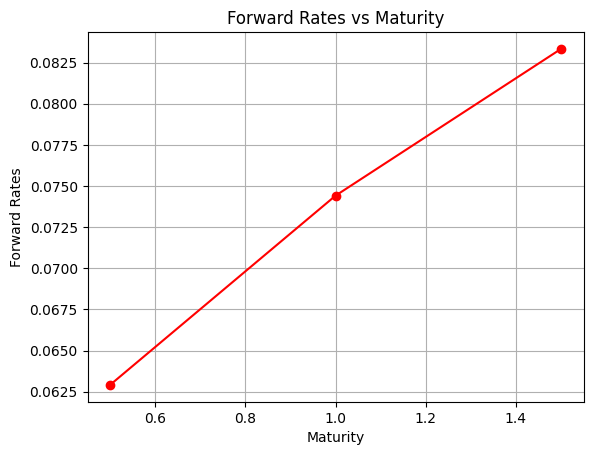

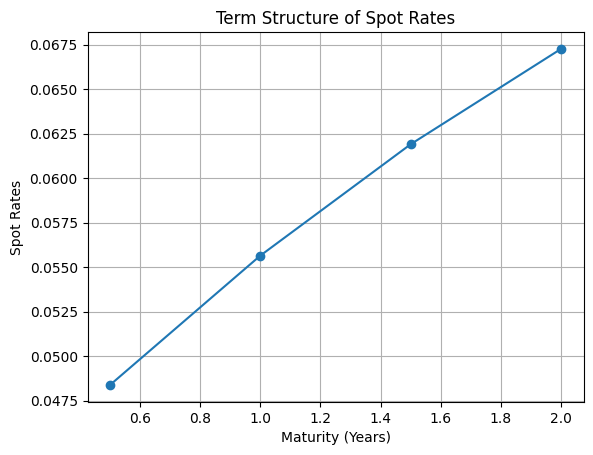

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# given code to perform backsubstitution and solve y = Ax (A nxn)
def backsub(A, y):
    n = len(A)
    x = np.zeros(n)

    for i in range(0, n):
        tmp = y[i]
        for j in range(0, i):
            tmp -= x[j] * A[i, j]
        x[i] = tmp / A[i, i]

    return x

data = {
    "Bond Name": ['A', 'B', 'C', 'D'],
    "Maturity": [0.5, 1.0, 1.5, 2.0],
    "Bond Price": [985.86, 974.70, 967.99, 966.82],
    "Coupon Rate": [0.02, 0.03, 0.04, 0.05],
    "Face Value": [1000, 1000, 1000, 1000]
}

df = pd.DataFrame(data)
df['Coupon'] = df['Coupon Rate'] * df['Face Value'] / 2  # Semi-annual coupons

# PART A

# solve for discount factors
N = len(df)
time_periods = np.arange(0.5, 0.5 * N + 0.1, 0.5)  # [0.5, 1.0, 1.5, 2.0]
A = np.zeros((N, N))
y = df['Bond Price'].values

# construct A matrix
for i in range(N):

    # num coupon payments
    num_payments = int(df.loc[i, 'Maturity'] / 0.5)

    for j in range(num_payments):
        if j == num_payments - 1:
            # last payment includes face value
            A[i, j] = df.loc[i, 'Coupon'] + df.loc[i, 'Face Value']
        else:
            A[i, j] = df.loc[i, 'Coupon']

# use backsub to solve for discount factors
discount_factors = backsub(A, y)
print(f"Discount factors are: {discount_factors}, respectively")

# using the equation in unit 3 deck 4 slide 12
spot_rates = np.array(-np.log(discount_factors) / time_periods)
print(f"Spot rates are: {spot_rates}, respectively")


# PART B - calculate forward rates for f(0, 0.5m, 0.5m + 0.5)
forward_rates = []

for i in range(N - 1):
    Z_T1 = discount_factors[i]
    Z_T2 = discount_factors[i + 1]
    T1 = time_periods[i]
    T2 = time_periods[i + 1]

    fwd_rate = (-np.log(Z_T2 / Z_T1)) / (T2 - T1)
    forward_rates.append(fwd_rate)

forward_rates = np.array(forward_rates)
print(f"Forward rates are: {forward_rates}, respectively")

# didn't really know how to plot the forward rates as there's 3 points (for four maturity points)
# so just chose the midpoints between each point
forward_maturities = [0.5, 1, 1.5]

plt.figure()
plt.plot(forward_maturities, forward_rates, marker='o', color='red')
plt.title('Forward Rates vs Maturity')
plt.xlabel('Maturity')
plt.ylabel('Forward Rates')
plt.grid()


plt.figure()
plt.plot(time_periods, spot_rates, marker='o', label="Spot Rates")
plt.title('Term Structure of Spot Rates')
plt.xlabel('Maturity (Years)')
plt.ylabel('Spot Rates')
plt.grid()

Question 2 - YTM and Bond Price

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09]


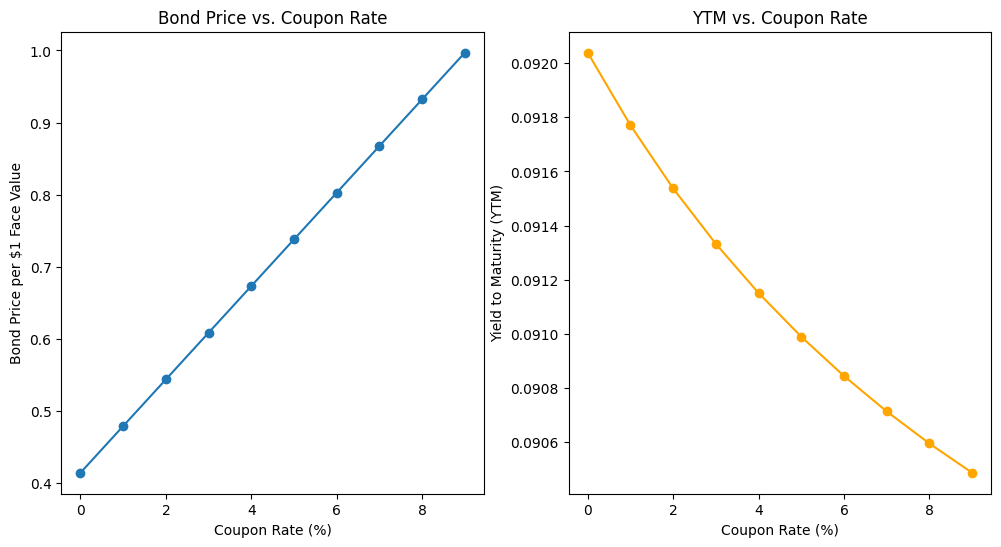

In [ ]:
import scipy.optimize as optimize
import numpy as np

# YTM = yield to maturity
    # represents a "average" rate of return over the time span of the bond

def bond_ytm(price, FaceVal, T, coup, freq=2, guess=0.05):
    freq = float(freq)
    periods = T * freq
    coupon= coup / 100 * FaceVal / freq
    dt = [(i+1) / freq for i in range(int(periods))]

    ytm_func = lambda y: sum([coupon/(1+y/freq)**(freq*t) for t in dt]) + FaceVal/(1 + y / freq) ** periods-price

    return optimize.newton(ytm_func,guess)

# part A compute bond price w/ face value = 1
def bond_price(coupon_rate, T, r1, face_value=1):
    # cash flows at every point in time
    cash_flows = [coupon_rate * face_value for _ in range(T)]

    # add face value to the last payment
    cash_flows[-1] += face_value

    # rewriting equation on unit 3 lecture 3 slide 6
    # to have price in terms of coupon rate and term structure
    price = 0
    for t, cf in enumerate(cash_flows):
        price += cf * np.exp(-r1(t + 1)) ** (t + 1)

    return price

# nelson-siegel term structure r1 for given time T
def r1(T):
    return beta0 + (beta1 + beta2) * tau / T * (1 - np.exp(-T / tau)) - beta2 * np.exp(-T / tau)

beta0 = 0.02
beta1 = 0.02
beta2 = 0.20
tau = 5

N = 10
face_value = 1
coupon_rates = np.linspace(0, 0.09, 10)

print(coupon_rates)

bond_prices = []
ytm_values = []

for cr in coupon_rates:
    price = bond_price(cr, N, r1, face_value)
    bond_prices.append(price)
    ytm = bond_ytm(price, face_value, N, cr * 100, freq=1)
    ytm_values.append(ytm)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(coupon_rates * 100, bond_prices, marker='o')
plt.xlabel("Coupon Rate (%)")
plt.ylabel("Bond Price per $1 Face Value")
plt.title("Bond Price vs. Coupon Rate")

plt.subplot(1, 2, 2)
plt.plot(coupon_rates * 100, ytm_values, marker='o', color='orange')
plt.xlabel("Coupon Rate (%)")
plt.ylabel("Yield to Maturity (YTM)")
plt.title("YTM vs. Coupon Rate")

plt.show()

Question 3 - Extra Credit adding noise and fitting model to data

In [ ]:
import numpy as np
import scipy.optimize as optimize
import matplotlib.pyplot as plt

# nelson-siegel term structure r1 for given time T
def r1(T, beta0, beta1, beta2, tau):
    return beta0 + (beta1 + beta2) * tau / T * (1 - np.exp(-T / tau)) - beta2 * np.exp(-T / tau)

beta0 = 0.02
beta1 = 0.02
beta2 = 0.20
tau = 5

N = 10
T = np.linspace(1, 10, 10)

# original term structure
r_true = np.array([r1(t, beta0, beta1, beta2, tau) for t in T])

# residual function to determine error for least squares fitting
def residuals(params, T, r_observed):
    beta0, beta1, beta2, tau = params
    r_model = np.array([r1(t, beta0, beta1, beta2, tau) for t in T])
    return r_model - r_observed

# initial parameter "guesses" for least squares model
initial_params = [0.01, 0.01, 0.1, 2.0]

# fit the model to original data
result = optimize.least_squares(residuals, initial_params, args=(T, r_true))
beta0_fit, beta1_fit, beta2_fit, tau_fit = result.x

print("Fitted parameters to original data:")
print(f"beta0 = {beta0_fit}")
print(f"beta1 = {beta1_fit}")
print(f"beta2 = {beta2_fit}")
print(f"tau = {tau_fit}")

# choose 1, 5, 10, 20, and 50 basis points
noise_levels = [0.0001, 0.0005, 0.001, 0.002, 0.005]
results = []

for noise_level in noise_levels:
    # choose random noise level (+-)
    # need size=len(r_true) to ensure that each term structure data point receives an independent noise value
    noise = np.random.choice([noise_level, -noise_level], size=len(r_true))
    r_noisy = r_true + noise

    result_noisy = optimize.least_squares(residuals, initial_params, args=(T, r_noisy))
    beta0_fit_noisy, beta1_fit_noisy, beta2_fit_noisy, tau_fit_noisy = result_noisy.x

    results.append({
        'noise_level': noise_level,
        'beta0': beta0_fit_noisy,
        'beta1': beta1_fit_noisy,
        'beta2': beta2_fit_noisy,
        'tau': tau_fit_noisy
    })

print("\nFitted parameters for different noise levels:")
for result in results:
    print(f"\nNoise level: {result['noise_level'] * 10000:.1f} basis points")
    print(f"beta0 = {result['beta0']}")
    print(f"beta1 = {result['beta1']}")
    print(f"beta2 = {result['beta2']}")
    print(f"tau = {result['tau']}")

Fitted parameters to original data:
beta0 = 0.02000000001159872
beta1 = 0.01999999998837415
beta2 = 0.199999999982589
tau = 4.999999999822644

Fitted parameters for different noise levels:

Noise level: 1.0 basis points
beta0 = 0.01900852843501741
beta1 = 0.020918653659606525
beta2 = 0.20163095479373777
tau = 5.013159427363021

Noise level: 5.0 basis points
beta0 = 0.047785382363472725
beta1 = -0.009845419539312455
beta2 = 0.1533038265084543
tau = 4.115831089708771

Noise level: 10.0 basis points
beta0 = 0.07180550090451632
beta1 = -0.03609617628906599
beta2 = 0.10641020490571808
tau = 3.1008134636086035

Noise level: 20.0 basis points
beta0 = -0.022475936911925006
beta1 = 0.058825955050387485
beta2 = 0.27947482439033045
tau = 5.663739691292254

Noise level: 50.0 basis points
beta0 = 0.08337130186831704
beta1 = -0.042560078070053145
beta2 = 0.08101723476927589
tau = 3.0151527292502145


Question 4 - Macauley Duration

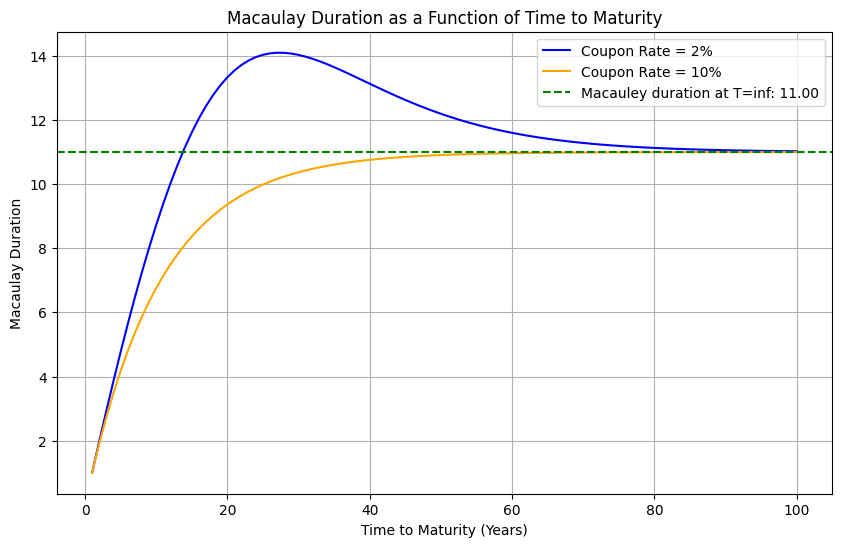

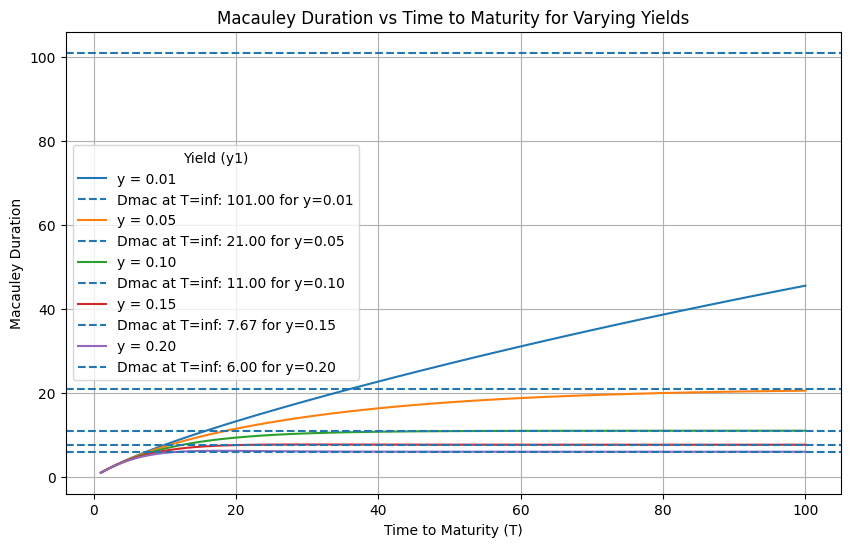

In [ ]:
import matplotlib.pyplot as plt

def macauley_duration(y, c, T):
    num = T * (y - c) - (1 + y)
    den = c * (pow(1 + y, T) - 1) + y

    return 1 + 1 / y + num / den

y1 = 0.1
crs = [0.02, 0.10]
T_vals = np.linspace(1, 100, 100)

durations_c2 = [macauley_duration(y1, 0.02, T) for T in T_vals]
durations_c10 = [macauley_duration(y1, 0.10, T) for T in T_vals]

macd_inf = (1 + 1/y1)

plt.figure(figsize=(10, 6))
plt.plot(T_vals, durations_c2, label="Coupon Rate = 2%", color="blue")
plt.plot(T_vals, durations_c10, label="Coupon Rate = 10%", color="orange")
plt.axhline(y=macd_inf, color="green", linestyle="--", label=f"Macauley duration at T=inf: {macd_inf:.2f}")
plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Macaulay Duration")
plt.title("Macaulay Duration as a Function of Time to Maturity")
plt.legend()
plt.grid(True)
plt.show()

# now fix coupon rate and vary the YTM value
coupon_rate = 0.1
y1_vals = [0.01, 0.05, 0.1, 0.15, 0.2]
T_vals = np.linspace(1, 100, 100)

durations = {y: [macauley_duration(y, coupon_rate, T) for T in T_vals] for y in y1_vals}

plt.figure(figsize=(10, 6))
for y, duration in durations.items():
    macd_inf = (1 + 1/y)
    plt.plot(T_vals, duration, label=f"y = {y:.2f}")
    plt.axhline(y=macd_inf, linestyle="--", label=f"Dmac at T=inf: {macd_inf:.2f} for y={y:.2f}")

plt.xlabel("Time to Maturity (T)")
plt.ylabel("Macauley Duration")
plt.title("Macauley Duration vs Time to Maturity for Varying Yields")
plt.legend(title="Yield (y1)")
plt.grid()
plt.show()